# NYC Rideshare Forecasting Pipeline — Part 3: Exploratory Analysis

**Author:** K Flowers  
**GitHub:** [github.com/KRFlowers](https://github.com/KRFlowers)  
**Date:** December 2025

This notebook explores validated NYC rideshare trip data to identify demand patters and segment zones for forecasting. Using the cleaned dataset from notebook 01, it aggregates 683M trips to daily zone counts then analyzes global patterns, zone characteristics, and correlation structure. These findings will guide forecasting model design in notebook 03.

**Pipeline Position:** Notebook 3 of 4 — Exploratory Analysis

- 00_data_download.ipynb
- 01_data_validation.ipynb
- 02_exploratory_analysis.ipynb ← **this notebook**
- 03_demand_forecasting.ipynb

**Objective:** Analyze zone-level demand patterns and segment zones by correlation to inform forecasting model design.

**Technical Approach:**
- Aggregate 683M trip records to daily counts by zone
- Analyze global demand patterns (all zones combined)
- Analyze zone-specific volume, variability, and correlations

**Inputs:**
- `data/validated/fhvhv_valid_data_for_eda.parquet` — Validated trips from notebook 01

**Outputs:**
- `zone_daily_full.parquet` — Complete dataset (256 zones)
- `zone_daily_high_corr.parquet` — High-correlation zones (195 zones - modeling subset)
- `zone_daily_low_corr.parquet` — Low-correlation zones (61 zones - specialized cases)

**Runtime:** ~10 minutes

## 1. Configure Environment

### 1.1 Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar

# Visualization
import matplotlib.pyplot as plt

# Utilities
import warnings

# Time series analysis
from statsmodels.tsa.stattools import adfuller

print("Libraries imported successfully")

Libraries imported successfully


### 1.2 Set Display and Plot Options

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
%matplotlib inline

warnings.filterwarnings('ignore')

# print display settings confirmation
print("Display settings configured")

Display settings configured


### 1.3 Set Paths and Constants

In [3]:
# Set constants

# Project timeframe
PROJECT_START = '2022-01-01'
PROJECT_END = '2024-12-31'
TLC_DATASET = 'fhvhv'

# Set file paths
PROJECT_ROOT = Path("..").resolve()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
VALIDATED_DIR = PROJECT_ROOT / "data" / "validated"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# Create input/output file paths
INPUT_FILE = VALIDATED_DIR / f"{TLC_DATASET}_valid_data_for_eda.parquet"
OUTPUT_FILE = PROCESSED_DIR / "zone_daily.parquet"
ZONE_STATS_FILE = PROCESSED_DIR / "zone_stats_summary.csv"

# Create directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Paths and constants set")

Paths and constants set


### 1.4 Create Database Connection

In [4]:
# Create DuckDB connection with optimized settings
con = duckdb.connect()
con.execute("SET threads=4")
con.execute("SET preserve_insertion_order=false")

print("DuckDB connection established")

DuckDB connection established


## 2. Load and Prepare Time-Series 
Aggregate to daily zone counts and add calendar features.

### 2.1 Load Raw Data

In [5]:
# Query dataset statistics
stats = con.execute(f"""
    SELECT 
        COUNT(*) as rows,
        COUNT(DISTINCT PULocationID) as zones,
        MIN(pickup_datetime) as start_date,
        MAX(pickup_datetime) as end_date
    FROM '{INPUT_FILE}'
""").fetchone()

# Get column count
col_count = len(con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df())

# Display summary
print("Raw Dataset Summary:")
print(f"  Total records:  {stats[0]:,}")
print(f"  Unique Zones:   {stats[1]}")
print(f"  Columns:        {col_count}")
print(f"  Date Range:     {str(stats[2])[:10]} to {str(stats[3])[:10]}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Raw Dataset Summary:
  Total records:  683,780,462
  Unique Zones:   263
  Columns:        24
  Date Range:     2022-01-01 to 2024-12-31


In [6]:
# Query company breakdown
companies = con.execute(f"""
    SELECT 
        hvfhs_license_num as company,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY hvfhs_license_num
    ORDER BY trips DESC
""").df()

companies['pct'] = (companies['trips'] / companies['trips'].sum() * 100).round(1)

print("\nCompany Distribution:")
display(companies)


Company Distribution:


,company,trips,pct
0,HV0003,499553891,73.1000
1,HV0005,184226571,26.9000


### 2.2 Aggregate to Daily Zone Counts

In [7]:
# Aggregate to daily counts by zone
zone_daily = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        CAST(pickup_datetime AS DATE) as date,
        COUNT(*) as daily_trips,
        SUM(trip_time) as daily_total_minutes,
        AVG(trip_time) as daily_avg_minutes,
        SUM(trip_miles) as total_trip_miles,
        AVG(trip_miles) as avg_trip_miles,
        SUM(base_passenger_fare) as total_fare,
        AVG(base_passenger_fare) as avg_fare
    FROM '{INPUT_FILE}'
    GROUP BY PULocationID, CAST(pickup_datetime AS DATE)
    ORDER BY PULocationID, date
""").df()

# Convert date column to datetime
zone_daily['date'] = pd.to_datetime(zone_daily['date'])

print("Aggregated Dataset")
print(f"  Records: {len(zone_daily):,}")
print(f"  Zones: {zone_daily['zone_id'].nunique()}")
print(f"  Date range: {zone_daily['date'].min().date()} to {zone_daily['date'].max().date()}")
print(f"  Days: {(zone_daily['date'].max() - zone_daily['date'].min()).days + 1}")

zone_daily.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Aggregated Dataset
  Records: 283,528
  Zones: 263
  Date range: 2022-01-01 to 2024-12-31
  Days: 1096


,zone_id,date,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,total_fare,avg_fare
0,1,2022-02-22,1,1138.0000,1138.0000,1.6600,1.6600,22.7300,22.7300
1,1,2022-03-11,3,2544.0000,848.0000,40.2900,13.4300,91.6900,30.5633
2,1,2022-03-13,7,14335.0000,2047.8571,71.0300,10.1471,377.1900,53.8843
3,1,2022-03-16,1,258.0000,258.0000,1.9700,1.9700,174.7000,174.7000
4,1,2022-04-28,1,649.0000,649.0000,7.0100,7.0100,81.5400,81.5400


### 2.3 Verify Data Quality 
Verify aggregated dataset has no missing values and complete temporal coverage.

In [8]:
# Check for missing values
print("Missing Values Check")
missing_counts = zone_daily.isnull().sum()
if missing_counts.sum() == 0:
    print("  No missing values detected")
else:
    print("  Missing values found:")
    print(missing_counts[missing_counts > 0])


Missing Values Check
  No missing values detected


In [9]:
# Verify complete temporal coverage per zone
print("\nTemporal Coverage Verification")

# Calculate expected days from project timeframe constants
project_start = pd.to_datetime(PROJECT_START)
project_end = pd.to_datetime(PROJECT_END)
expected_days = (project_end - project_start).days + 1

# Count actual days with data for each zone
zone_coverage = zone_daily.groupby('zone_id')['date'].nunique().reset_index()
zone_coverage.columns = ['zone_id', 'days_with_data']
zone_coverage['missing_days'] = expected_days - zone_coverage['days_with_data']

# Identify complete vs incomplete zones
zones_complete = zone_coverage[zone_coverage['missing_days'] == 0]['zone_id'].tolist()
zones_incomplete = zone_coverage[zone_coverage['missing_days'] > 0]['zone_id'].tolist()

# Calculate data impact
total_records = len(zone_daily)
total_incomplete_records = len(zone_daily[zone_daily['zone_id'].isin(zones_incomplete)])
pct_zones_complete = len(zones_complete) / len(zone_coverage) * 100
pct_data_incomplete = total_incomplete_records / total_records * 100

print(f"  Expected coverage: {PROJECT_START} to {PROJECT_END} ({expected_days} days)")
print(f"  Zones with complete coverage: {len(zones_complete)} / {len(zone_coverage)} ({pct_zones_complete:.1f}%)")
print(f"  Records from incomplete zones: {total_incomplete_records:,} / {total_records:,} records ({pct_data_incomplete:.2f}%)")   
if zones_incomplete:
    print(f"\n  Zones with incomplete coverage: {len(zones_incomplete)}")
    display(zone_coverage[zone_coverage['zone_id'].isin(zones_incomplete)])
    


Temporal Coverage Verification
  Expected coverage: 2022-01-01 to 2024-12-31 (1096 days)
  Zones with complete coverage: 256 / 263 (97.3%)
  Records from incomplete zones: 2,952 / 283,528 records (1.04%)

  Zones with incomplete coverage: 7


,zone_id,days_with_data,missing_days
0,1,44,1052
1,2,757,339
102,105,118,978
107,110,669,427
196,199,268,828
250,253,1095,1
261,264,1,1095


In [10]:
# Filter out incomplete zones
zone_daily = zone_daily[zone_daily['zone_id'].isin(zones_complete)].copy()

print(f"\nFiltered dataset (only zones with complete coverage):")
print(f"  Records: {len(zone_daily):,}")
print(f"  Zones: {zone_daily['zone_id'].nunique()}")


Filtered dataset (only zones with complete coverage):
  Records: 280,576
  Zones: 256


**Modeling Implication:** Seven zones with incomplete coverage (1% of data) were excluded to ensure consistent time series length for forecasting models.

### 2.4 Add Calendar Features
Add calendar feature columns: year, month, day_of_week, day_name, is_weekend, season, is_holiday.

In [11]:
# Add  calendar features to zone_daily dataframe
zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6])

# Season (meteorological)
zone_daily['season'] = zone_daily['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

# Holiday flag
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2022-01-01', end='2024-12-31')
zone_daily['is_holiday'] = zone_daily['date'].isin(holidays)

print("Calendar features added:")
print(f"  Features: year, month, day_of_week, day_name, is_weekend, season, is_holiday")
print(f"  Records: {len(zone_daily):,}")
print(f"  Columns: {len(zone_daily.columns)}")

Calendar features added:
  Features: year, month, day_of_week, day_name, is_weekend, season, is_holiday
  Records: 280,576
  Columns: 16


### 2.5 Save Aggregated Dataset

In [12]:
# Save zone-daily dataset
zone_daily.to_parquet(OUTPUT_FILE, index=False)
print(f"\n Saved: {OUTPUT_FILE.name}")
print(f"  Rows: {len(zone_daily):,}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.1f} MB")


 Saved: zone_daily.parquet
  Rows: 280,576
  Size: 14.0 MB


## 3. Analyze Global Demand Patterns
Review the daily trip demand to identify trends or anomalies.

### 3.1 Examine Global Daily Demand
Review overall daily trip demand to identify trends or anomalies.

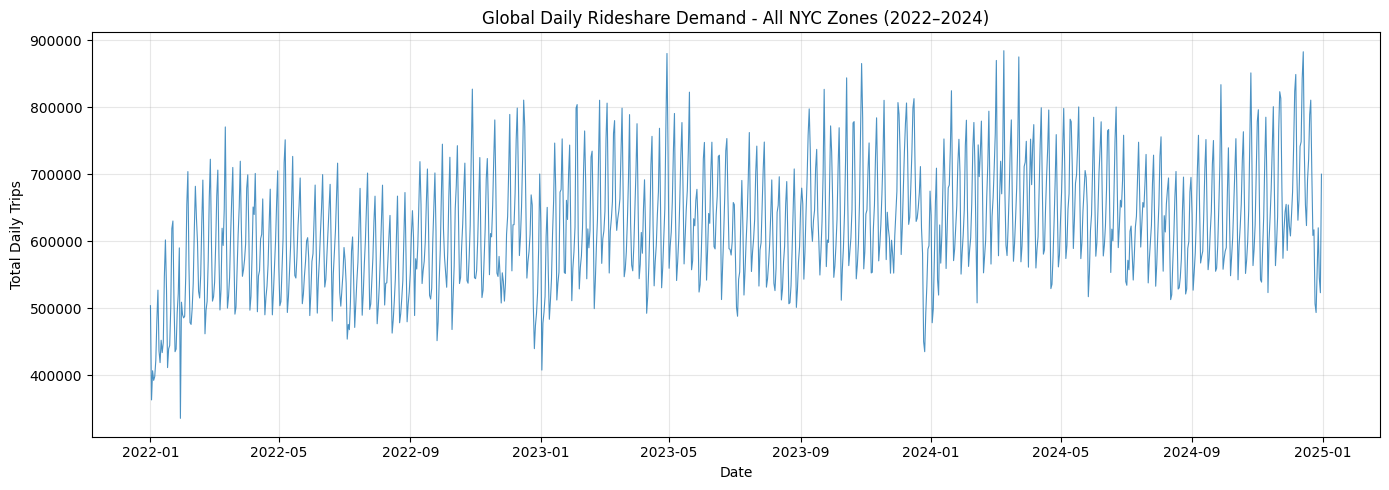

In [13]:
# Calculate global daily totals (sum across all zones)
daily_total = zone_daily.groupby('date')['daily_trips'].sum().reset_index()
daily_total.columns = ['date', 'total_trips']

# Plot overall trend
plt.figure(figsize=(14, 5))
plt.plot(daily_total['date'], daily_total['total_trips'], linewidth=0.8, alpha=0.8)
plt.title('Global Daily Rideshare Demand - All NYC Zones (2022–2024)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Total Daily Trips')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation:** Daily demand fluctuates with visible weekly cycles but remains stable across the analysis period. Slight 2022 growth may reflect post-COVID recovery.

### 3.2 Test for Stationarity
Use Augmented Dickey-Fuller test to verify demand has no underlying trend.

In [14]:
# Perform Augmented Dickey-Fuller test

result = adfuller(daily_total['total_trips']) 

print("Stationarity Test (Augmented Dickey-Fuller)")
print(f"  ADF Statistic: {result[0]:.4f}")
print(f"  p-value: {result[1]:.4f}")
print(f"  Critical Values:")
for key, value in result[4].items():
    print(f"    {key}: {value:.4f}")

if result[1] < 0.05:
    print(f"\n  Data is stationary (p < 0.05)")
    print(f"  Demand fluctuates around stable mean without persistent trend")
else:
    print(f"\n  Data is non-stationary (p >= 0.05)")
    print(f"  Trend present - may require differencing")

Stationarity Test (Augmented Dickey-Fuller)
  ADF Statistic: -4.2531
  p-value: 0.0005
  Critical Values:
    1%: -3.4365
    5%: -2.8642
    10%: -2.5682

  Data is stationary (p < 0.05)
  Demand fluctuates around stable mean without persistent trend


**Modeling Implication:** Stationary data means no detrending or decomposition will be needed. Data can be model demand directly.

### 3.3 Examine Global Demand Variability
Use 30-day rolling statistics to assess whether variance remains constant over time.

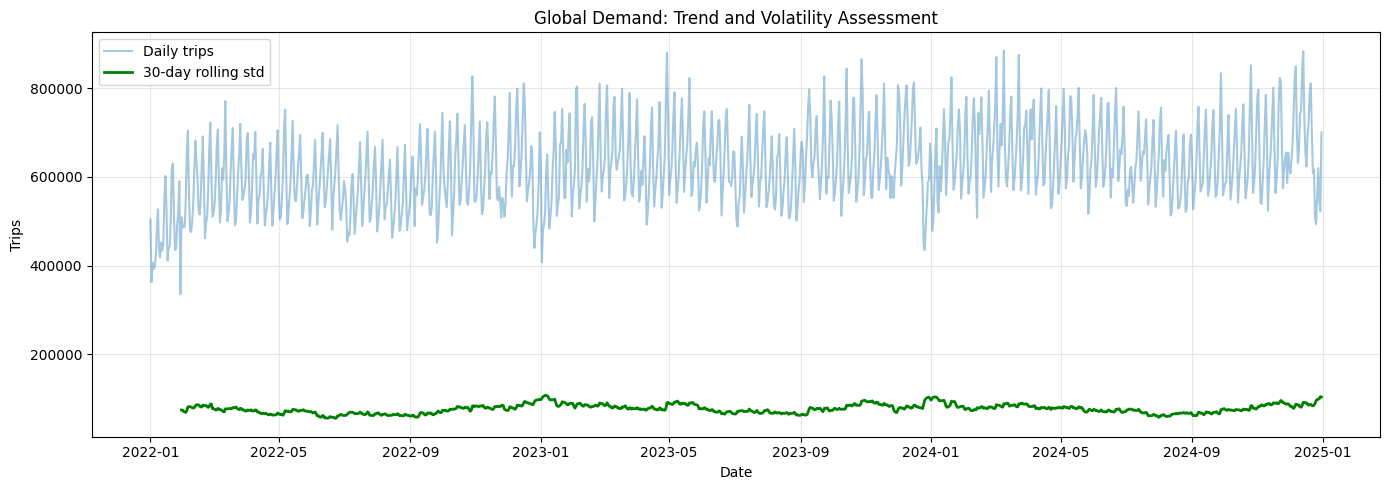

In [15]:
# Create time series with continuous daily index
daily_ts = daily_total.set_index('date')['total_trips'].asfreq('D')

ROLL_DAYS = 30  # 30-day rolling window
rolling_std = daily_ts.rolling(ROLL_DAYS).std()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily_ts.index, daily_ts.values, alpha=0.4, label='Daily trips')
plt.plot(rolling_std.index, rolling_std.values, linewidth=2, label=f'{ROLL_DAYS}-day rolling std', color='green')
plt.title('Global Demand: Trend and Volatility Assessment', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Demand Variability:** The 30-day rolling standard deviation (green line) shows stable volatility - variance does not increase with demand level.

**Modeling Implication:** Constant variance supports an **additive** model structure.

### 3.4 Examine Global Seasonal Patterns
Examine demand patterns for daily, weekly, and monthly seasonality.

In [16]:
# Calculate average daily trips by day of week
dow_avg = zone_daily.groupby(['day_of_week', 'day_name'])['daily_trips'].mean().reset_index()
dow_avg = dow_avg.sort_values('day_of_week')  # Already in correct order

# Add month_name if not present
if 'month_name' not in zone_daily.columns:
    zone_daily['month_name'] = zone_daily['date'].dt.month_name()

# Calculate average by year and month, keep month number for sorting
monthly_by_year = zone_daily.groupby(['year', 'month', 'month_name'])['daily_trips'].mean().reset_index()
monthly_by_year = monthly_by_year.sort_values(['year', 'month']) 


print("Seasonal aggregations calculated")
#monthly_by_year.head()

Seasonal aggregations calculated


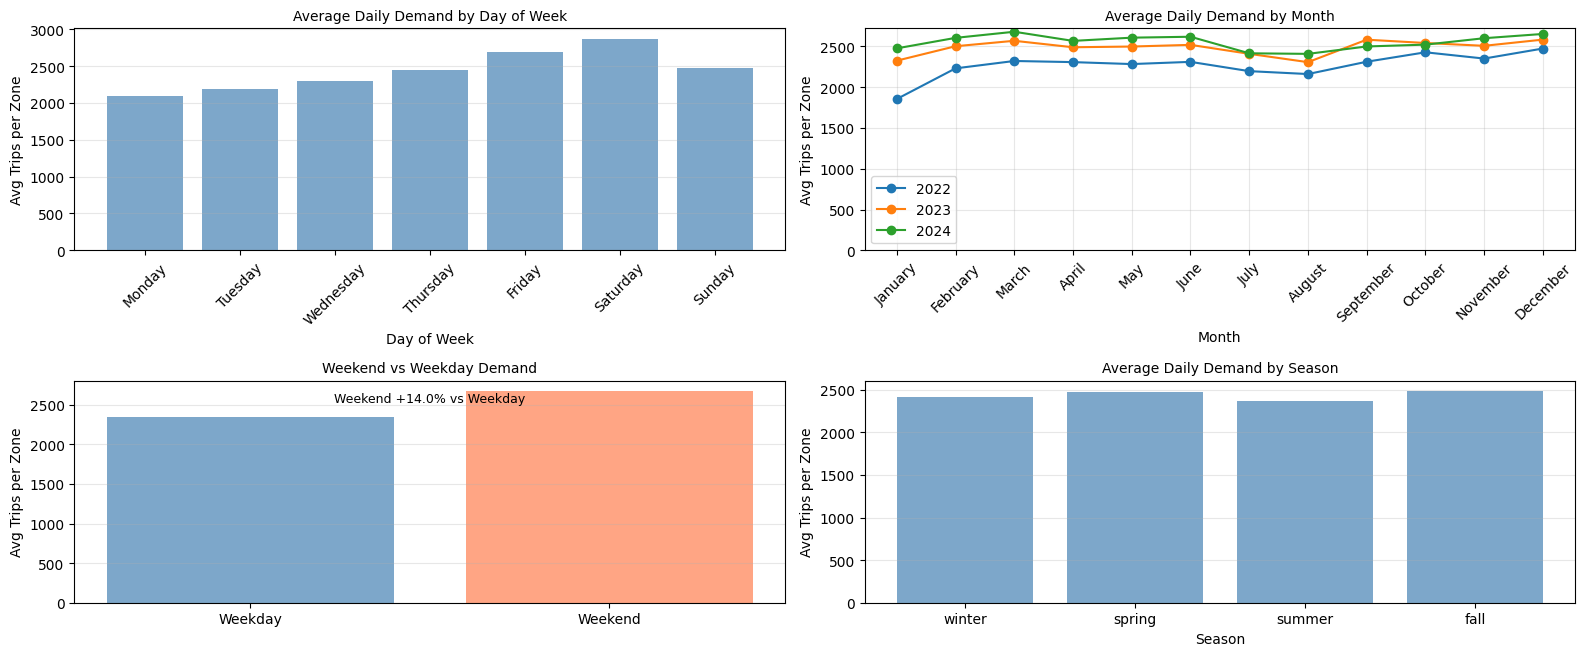

In [17]:
# Visualize global patterns at multiple time scales
fig = plt.figure(figsize=(16, 10))

# Day-of-week patterns
ax2 = fig.add_subplot(3, 2, 3)
ax2.bar(dow_avg['day_name'], dow_avg['daily_trips'], color='steelblue', alpha=0.7)
ax2.set_title('Average Daily Demand by Day of Week', fontsize=10)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Avg Trips per Zone')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Monthly patterns
ax3 = fig.add_subplot(3, 2, 4)
for year in [2022, 2023, 2024]:
    data = monthly_by_year[monthly_by_year['year'] == year]
    ax3.plot(data['month_name'], data['daily_trips'], marker='o', label=str(year))
ax3.set_title('Average Daily Demand by Month', fontsize=10)
ax3.set_xlabel('Month')
ax3.set_ylabel('Avg Trips per Zone')
ax3.set_ylim(0, None)  # Start at 0, auto-scale top
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Weekend vs Weekday
ax4 = fig.add_subplot(3, 2, 5)
weekend_avg = zone_daily[zone_daily['is_weekend']]['daily_trips'].mean()
weekday_avg = zone_daily[~zone_daily['is_weekend']]['daily_trips'].mean()
ax4.bar(['Weekday', 'Weekend'], [weekday_avg, weekend_avg], color=['steelblue', 'coral'], alpha=0.7)
ax4.set_title('Weekend vs Weekday Demand', fontsize=10)
ax4.set_ylabel('Avg Trips per Zone')
ax4.grid(True, alpha=0.3, axis='y')
pct_diff = ((weekend_avg - weekday_avg) / weekday_avg * 100)
ax4.text(0.5, 0.95, f'Weekend {pct_diff:+.1f}% vs Weekday', 
         transform=ax4.transAxes, ha='center', va='top', fontsize=9)

# Seasonal patterns
ax5 = fig.add_subplot(3, 2, 6)
season_avg = zone_daily.groupby('season')['daily_trips'].mean().reindex(['winter', 'spring', 'summer', 'fall'])
ax5.bar(season_avg.index, season_avg.values, color='steelblue', alpha=0.7)
ax5.set_title('Average Daily Demand by Season', fontsize=10)
ax5.set_xlabel('Season')
ax5.set_ylabel('Avg Trips per Zone')
ax5.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Global demand shows the following seasonal patterns:
- **Weekly:** Demand increases through the week, peaking Saturday. Weekend days show slightly higher demand (+13%)
- **Monthly:** Summer months (June-August) show consistent lows
- **Annual:** 2022 shows modest growth that stabilizes in 2023-2024
- **Seasonal:** Minimal variation (summer slightly lower, winter/spring/fall similar)

**Modeling Implication:** Weekly patterns dominate. Analyzing zone characteristics will determine if patterns are consistent or require different modeling approaches.

## 4. Analyze Zone Characteristics
Examine how individual zones differ in volume, variability, and temporal patterns.

### 4.1 Analyze Zone Volume Distribution

In [18]:
# Calculate total trips per zone
zone_totals = zone_daily.groupby('zone_id')['daily_trips'].sum().reset_index()
zone_totals.columns = ['zone_id', 'total_trips']
zone_totals = zone_totals.sort_values('total_trips', ascending=False).reset_index(drop=True)
zone_totals['pct_of_total'] = (zone_totals['total_trips'] / zone_totals['total_trips'].sum() * 100).round(2)
zone_totals['cumulative_pct'] = zone_totals['pct_of_total'].cumsum()

print(" Zone volume metrics calculated")

 Zone volume metrics calculated


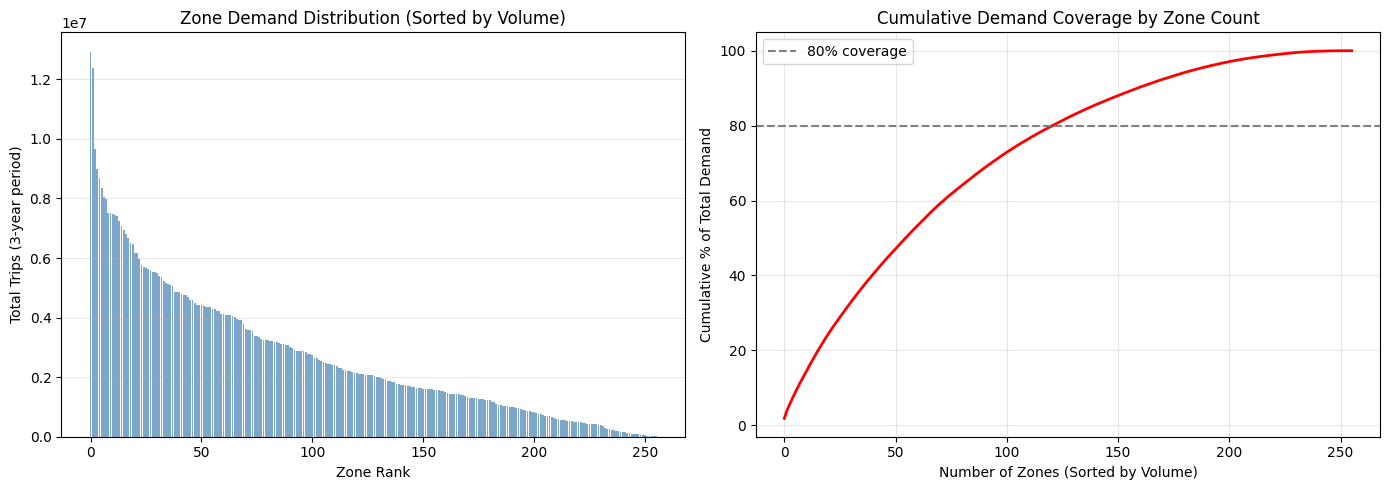


Cumulative Demand Distribution:
  Top  10 zones:  13.5%
  Top  20 zones:  23.7%
  Top  50 zones:  46.5%
  Top 100 zones:  72.5%
  Top 150 zones:  87.8%
  Top 200 zones:  96.9%

  Total zones: 256


In [19]:
# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Zone volume distribution
ax1.bar(range(len(zone_totals)), zone_totals['total_trips'], color='steelblue', alpha=0.7)
ax1.set_title('Zone Demand Distribution (Sorted by Volume)', fontsize=12)
ax1.set_xlabel('Zone Rank')
ax1.set_ylabel('Total Trips (3-year period)')
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative coverage
ax2.plot(range(len(zone_totals)), zone_totals['cumulative_pct'], linewidth=2, color='red')
ax2.set_title('Cumulative Demand Coverage by Zone Count', fontsize=12)
ax2.set_xlabel('Number of Zones (Sorted by Volume)')
ax2.set_ylabel('Cumulative % of Total Demand')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=80, color='gray', linestyle='--', label='80% coverage')
ax2.legend()

plt.tight_layout()
plt.show()

# Coverage statistics
print("\nCumulative Demand Distribution:")
for n in [10, 20, 50, 100, 150, 200]:
    if n <= len(zone_totals):
        pct = zone_totals.iloc[:n]['cumulative_pct'].iloc[-1]
        print(f"  Top {n:3d} zones: {pct:5.1f}%")

print(f"\n  Total zones: {len(zone_totals)}")

Demand is spread across zones rather than concentrated in a few high-volume zones. The top 100 zones containing 72.5% of trips, indicating most zones contribute meaningful demand levels rather than a few zones dominating.

**Modeling Implication:** Broad demand distribution across zones supports modeling the majority of zones rather than focusing only on high-volume areas.

### 4.2 Analyze Within-Zone Stability 
Calculate coefficient of variation (CV) to measure demand stability within each zone.

Zone Variability Summary:
  Highest avg daily demand: 11,800 trips/day
  Lowest avg daily demand:  13 trips/day
  Most volatile zone (CV):  1.334
  Most stable zone (CV):    0.113
  Median CV:                0.173


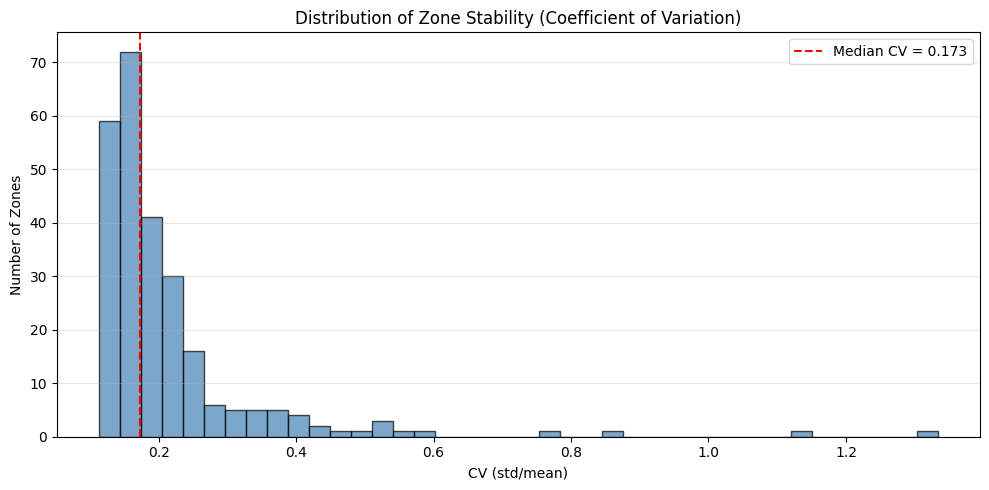

In [20]:
# Calculate zone-level statistics
zone_stats = zone_daily.groupby('zone_id').agg({
    'daily_trips': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'daily_avg_minutes': 'mean',
    'avg_trip_miles': 'mean'
}).round(2)

# Flatten column names
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns.values]
zone_stats = zone_stats.reset_index()

# Calculate coefficient of variation (CV = std/mean)
zone_stats['cv'] = (zone_stats['daily_trips_std'] / zone_stats['daily_trips_mean']).round(3)

# Summary statistics
print("Zone Variability Summary:")
print(f"  Highest avg daily demand: {zone_stats['daily_trips_mean'].max():,.0f} trips/day")
print(f"  Lowest avg daily demand:  {zone_stats['daily_trips_mean'].min():,.0f} trips/day")
print(f"  Most volatile zone (CV):  {zone_stats['cv'].max():.3f}")
print(f"  Most stable zone (CV):    {zone_stats['cv'].min():.3f}")
print(f"  Median CV:                {zone_stats['cv'].median():.3f}")

# Visualize CV distribution
plt.figure(figsize=(10, 5))
plt.hist(zone_stats['cv'], bins=40, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Zone Stability (Coefficient of Variation)', fontsize=12)
plt.xlabel('CV (std/mean)')
plt.ylabel('Number of Zones')
plt.axvline(x=zone_stats['cv'].median(), color='red', linestyle='--', label=f'Median CV = {zone_stats["cv"].median():.3f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


Zone volumes range from 13 to 11,800 trips/day, but within-zone demand is stable (median CV 0.17).

**Modeling Implication:** This consistency supports a straightforward lag-based forecasting approach.

### 4.3 Analyze Zone Pattern Similarity
Measure how closely individual zones follow the global demand pattern. This reveals whether zones share consistent patterns or exhibit heterogeneous behavior.

In [21]:
# Calculate zone-to-global correlation to detect pattern heterogeneity

# Calculate global (system-wide) daily demand
global_demand = daily_total.rename(columns={'total_trips': 'global_trips'})
global_demand.columns = ['date', 'global_trips']

# Merge global demand with zone data
zone_with_global = zone_daily.merge(global_demand, on='date')

# Calculate correlation between each zone and global pattern
zone_global_corr = zone_with_global.groupby('zone_id').apply(
    lambda x: x['daily_trips'].corr(x['global_trips'])
).reset_index()
zone_global_corr.columns = ['zone_id', 'correlation_to_global']

# Merge correlation into zone stats and save
zone_stats_final = zone_stats.merge(
    zone_global_corr[['zone_id', 'correlation_to_global']], 
    on='zone_id', 
    how='left'
)

# save zone statistics with correlation
zone_stats_final.to_csv(ZONE_STATS_FILE, index=False)
print(f"\nZone statistics saved: {ZONE_STATS_FILE.name}")
print(f"  Zones: {len(zone_stats_final)}")
print(f"  Columns: {len(zone_stats_final.columns)} (includes correlation_to_global)")

# Summary statistics
corr_stats = zone_global_corr['correlation_to_global'].describe()
corr_range = zone_global_corr['correlation_to_global'].max() - zone_global_corr['correlation_to_global'].min()  

# Assess what percentage of demand each correlation group represents
high_corr_zones = zone_global_corr[zone_global_corr['correlation_to_global'] >= 0.6]['zone_id'].tolist()
low_corr_zones = zone_global_corr[zone_global_corr['correlation_to_global'] < 0.6]['zone_id'].tolist()

total_trips = zone_daily['daily_trips'].sum()
high_corr_trips = zone_daily[zone_daily['zone_id'].isin(high_corr_zones)]['daily_trips'].sum()
low_corr_trips = zone_daily[zone_daily['zone_id'].isin(low_corr_zones)]['daily_trips'].sum()

# print correlation statistics calculated
print("Corrrelation statistics calculated")


Zone statistics saved: zone_stats_summary.csv
  Zones: 256
  Columns: 11 (includes correlation_to_global)
Corrrelation statistics calculated


In [22]:
# Print correlation statistics
print("\nZone-to-Global Correlation Statistics:")
print(f"  Minimum:         {corr_stats['min']:.3f}")
print(f"  25th percentile: {corr_stats['25%']:.3f}")
print(f"  Median:          {corr_stats['50%']:.3f}")
print(f"  75th percentile: {corr_stats['75%']:.3f}")
print(f"  Maximum:         {corr_stats['max']:.3f}")
print(f"\nRange (spread):  {corr_range:.3f}")
print(f"  IQR:             {corr_stats['75%'] - corr_stats['25%']:.3f}")
print(f" Mean:            {corr_stats['mean']:.3f}")

print("\nData Coverage by Correlation Group")
print(f"  High-correlation (≥0.6): {len(high_corr_zones)} zones ({len(high_corr_zones)/len(zone_global_corr)*100:.1f}%), {high_corr_trips:,} trips ({high_corr_trips/total_trips*100:.1f}%)")
print(f"  Low-correlation (<0.6): {len(low_corr_zones)} zones ({len(low_corr_zones)/len(zone_global_corr)*100:.1f}%), {low_corr_trips:,} trips ({low_corr_trips/total_trips*100:.1f}%)")


Zone-to-Global Correlation Statistics:
  Minimum:         -0.281
  25th percentile: 0.613
  Median:          0.756
  75th percentile: 0.832
  Maximum:         0.947

Range (spread):  1.228
  IQR:             0.219
 Mean:            0.681

Data Coverage by Correlation Group
  High-correlation (≥0.6): 195 zones (76.2%), 560,701,826 trips (82.0%)
  Low-correlation (<0.6): 61 zones (23.8%), 123,036,084 trips (18.0%)


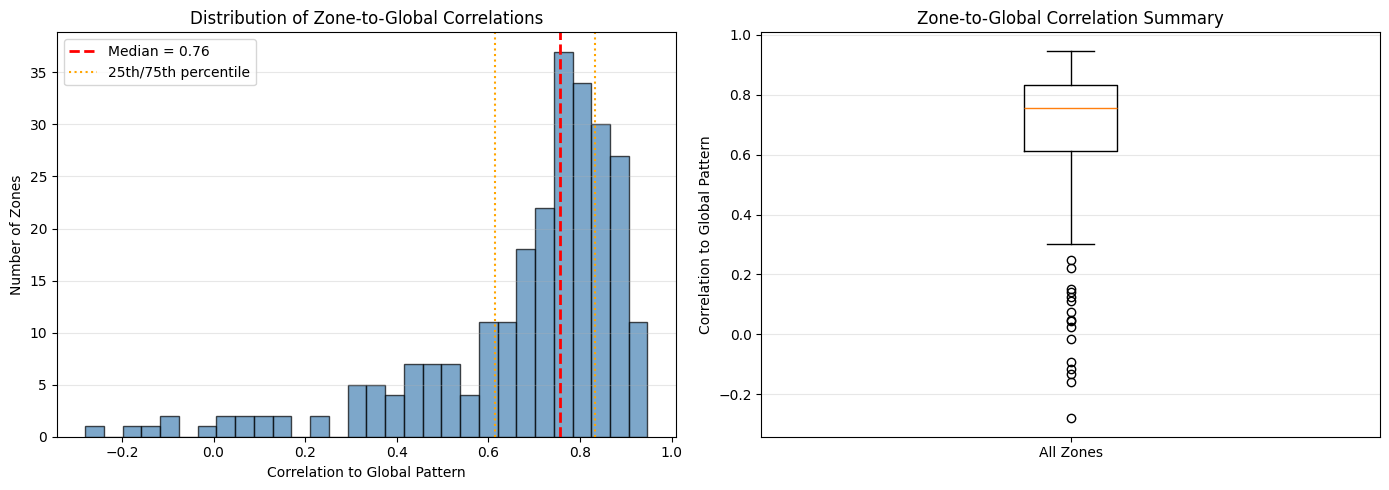

In [23]:
# Visualize distribution of zone-to-global correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
ax = axes[0]
ax.hist(zone_global_corr['correlation_to_global'], bins=30, color='steelblue', 
        alpha=0.7, edgecolor='black')
ax.axvline(zone_global_corr['correlation_to_global'].median(), 
           color='red', linestyle='--', linewidth=2,
           label=f"Median = {zone_global_corr['correlation_to_global'].median():.2f}")
ax.axvline(zone_global_corr['correlation_to_global'].quantile(0.25), 
           color='orange', linestyle=':', linewidth=1.5, label='25th/75th percentile')
ax.axvline(zone_global_corr['correlation_to_global'].quantile(0.75), 
           color='orange', linestyle=':', linewidth=1.5)
ax.set_xlabel('Correlation to Global Pattern')
ax.set_ylabel('Number of Zones')
ax.set_title('Distribution of Zone-to-Global Correlations')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Right: Box plot for quick summary
ax = axes[1]
ax.boxplot(zone_global_corr['correlation_to_global'], vert=True)
ax.set_ylabel('Correlation to Global Pattern')
ax.set_title('Zone-to-Global Correlation Summary')
ax.set_xticklabels(['All Zones'])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Most zones (75%, representing 82% of total trips) correlate strongly with global patterns. The remaining 25% show weaker or inverse correlations, likely representing specialized cases like airports or entertainment districts.

**Modeling Implication:** The high-correlation zones follow consistent weekly patterns and are appropriate for a single model. However, the low-correlation zones do not follow global patterns and a global model would perform poorly on them. For forecasting, the low-correlation zones will be excluded from initial modeling and saved separately for possible future evaluation.

## 5. Export Datasets
Based on the findings above, create three datasets: full (all zones with complete coverage), high-correlation (modeling subset), and low-correlation (for future analysis).


Create zone segmentation based on correlation threshold:

In [24]:
# Define correlation threshold and segment zones
HIGH_CORR_THRESHOLD = 0.6

high_corr_zones = zone_global_corr[
    zone_global_corr['correlation_to_global'] >= HIGH_CORR_THRESHOLD
]['zone_id'].tolist()

low_corr_zones = zone_global_corr[
    zone_global_corr['correlation_to_global'] < HIGH_CORR_THRESHOLD
]['zone_id'].tolist()

print(f"Zone Segmentation (threshold ≥ {HIGH_CORR_THRESHOLD})")
print(f"  High-correlation zones: {len(high_corr_zones)} ({len(high_corr_zones)/256*100:.1f}%)")
print(f"  Low-correlation zones:  {len(low_corr_zones)} ({len(low_corr_zones)/256*100:.1f}%)")
print(f"  Total zones:            {len(high_corr_zones) + len(low_corr_zones)}")

Zone Segmentation (threshold ≥ 0.6)
  High-correlation zones: 195 (76.2%)
  Low-correlation zones:  61 (23.8%)
  Total zones:            256


**Full dataset** — all zones with complete temporal coverage (256 zones)

In [25]:
# Export full dataset (all zones)
FULL_OUTPUT = PROCESSED_DIR / 'zone_daily_full.parquet'
zone_daily.to_parquet(FULL_OUTPUT, index=False)

print(f"Full dataset exported:")
print(f" File:       {FULL_OUTPUT.name}")
print(f" Zones:      {zone_daily['zone_id'].nunique()}")
print(f" Records:    {len(zone_daily):,}")
print(f" Size:       {FULL_OUTPUT.stat().st_size / 1024 / 1024:.1f} MB")

Full dataset exported:
 File:       zone_daily_full.parquet
 Zones:      256
 Records:    280,576
 Size:       14.0 MB


**High-correlation dataset** — zones for modeling (195 zones, 82% of trips)

In [26]:
# Export high-correlation zones dataset
zone_daily_high_corr = zone_daily[zone_daily['zone_id'].isin(high_corr_zones)].copy()

HIGH_CORR_OUTPUT = PROCESSED_DIR / 'zone_daily_high_corr.parquet'
zone_daily_high_corr.to_parquet(HIGH_CORR_OUTPUT, index=False)

print(f"High-correlation zones dataset exported:")
print(f" File:       {HIGH_CORR_OUTPUT.name}")
print(f" Zones:      {len(high_corr_zones)}")
print(f" Records:    {len(zone_daily_high_corr):,}")
print(f" Size:       {HIGH_CORR_OUTPUT.stat().st_size / 1024 / 1024:.1f} MB")

High-correlation zones dataset exported:
 File:       zone_daily_high_corr.parquet
 Zones:      195
 Records:    213,720
 Size:       11.1 MB


**Low-correlation dataset** — specialized zones for future analysis (61 zones)

In [27]:
# Export low-correlation zones dataset
zone_daily_low_corr = zone_daily[zone_daily['zone_id'].isin(low_corr_zones)].copy()

LOW_CORR_OUTPUT = PROCESSED_DIR / 'zone_daily_low_corr.parquet'
zone_daily_low_corr.to_parquet(LOW_CORR_OUTPUT, index=False)

print(f"Low-correlation zones dataset exported:")
print(f" File:       {LOW_CORR_OUTPUT.name}")
print(f" Zones:      {len(low_corr_zones)}")
print(f" Records:    {len(zone_daily_low_corr):,}")
print(f" Size:       {LOW_CORR_OUTPUT.stat().st_size / 1024 / 1024:.1f} MB")

print("\n\nData is ready for forecasting.")


Low-correlation zones dataset exported:
 File:       zone_daily_low_corr.parquet
 Zones:      61
 Records:    66,856
 Size:       3.7 MB


Data is ready for forecasting.


## Conclusion

Aggregated 683M trip records to daily zone counts and analyzed demand patterns at global and zone levels.

**Key Findings:**

*Global Patterns:*
- Weekly patterns dominate (weekend +13% vs weekday)
- Seasonal variation modest (summer lows)
- Demand is stationary with constant variance

*Zone-Level Characteristics:*
- 256 zones analyzed (7 removed for incomplete temporal coverage)
- Volume varies widely across zones (13 to 11,800 trips/day)
- Within-zone demand is stable (median CV 0.17)
- 75% of zones (82% of trips) correlate strongly with global patterns
- 25% are specialized cases (airports, entertainment districts)

**Modeling Implications:**
- Weekly patterns dominate → lag-based forecasting approach
- Stable within-zone demand → no variance transformations needed
- High-correlation zones (75%) → can share a single model
- Low-correlation zones (25%) → may need separate models

**Decision:** Separate datasets were created for high-correlation zones (195 zones, 82% of trips) and low-correlation zones (61 zones) based on correlation analysis.

**Outputs:**
- `zone_daily_full.parquet` — Complete dataset (256 zones)
- `zone_daily_high_corr.parquet` — High-correlation zones (195 zones - modeling subset)
- `zone_daily_low_corr.parquet` — Low-correlation zones (61 zones - specialized cases)

**Next Steps:**
Proceed to **03_demand_forecasting.ipynb** for feature engineering and model development.